In [1]:
import hakom
import json
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
import numpy as np
import getpass
import darts

In [2]:
api_pwd = getpass.getpass()

In [3]:
auth_params = hakom.authorization.AuthParams(
    username = 'aeneas',
    password = api_pwd,
)

service_config = hakom.service.ServiceConfig(
    base_url="https://fehostedwebapp.azurewebsites.net/MAIN/api/",
    auth_params=auth_params,
    repository='ZAMS'
)

hakom.initialize(service_config)

In [4]:
hakom.get_config().check_health()
hakom.versioninfo.get()

{'Name': 'HAKOM WebTSM Services',
 'Description': 'Time Series Management Webservices',
 'Version': '3.9.2.1-rc+0'}

Check if really logged in

In [5]:
units = pd.DataFrame.from_records(hakom.repositories.units.find())
units.head()

,ID,Name,Factor,Offset,BaseUnit,Aggregation,IntegralUnit,Description,Category
0,1,W,1.0,0.0,,AVG,Wh,None,None
1,2,kW,1000.0,0.0,W,AVG,kWh,None,None
2,3,kWh/h,1000.0,0.0,W,AVG,kWh,None,None
3,4,MW,1000000.0,0.0,W,AVG,MWh,None,None
4,5,MWh/h,1000000.0,0.0,W,AVG,MWh,None,None


# Lets load some data
are we?!

Get the start and end dates of observed and forecasted temperatures: 


In [6]:
# find series
metainfo_observed = hakom.repositories.timeseries.metainfo.get('491') # Observed load



Comment on Python client: function to load the entire time-series without passing the dates is missing

In [7]:
query_params = []
query_params.append(hakom.commons.QueryParam("id", "491"))
query_params.append(hakom.commons.QueryParam("id", "1134"))
query_params.append(hakom.commons.QueryParam("from", metainfo_observed['DataPeriod']['From']))
query_params.append(hakom.commons.QueryParam("to", metainfo_observed['DataPeriod']['To']))

timeseries_data= hakom.repositories.timeseriescollections.data.get(query_params,hakom.errorhandling.BulkResultBehaviours.FullResult)
matrix = hakom.converters.timeseries_data_collection_matrix(timeseries_data)
df = pd.DataFrame(matrix)
df.From=pd.to_datetime(df.From, utc=True)
df = df.set_index('From')
df = df.asfreq('H')


In [8]:
df.tail(5)

,Carga Sudeste/Centro-Oeste,Temperatura Subsistema SECO
From,,
2022-02-02 19:00:00+00:00,47158.3315,0.0
2022-02-02 20:00:00+00:00,48141.9600,0.0
2022-02-02 21:00:00+00:00,47557.5450,0.0
2022-02-02 22:00:00+00:00,45904.4575,0.0
2022-02-02 23:00:00+00:00,43515.6740,0.0


<AxesSubplot:xlabel='From'>

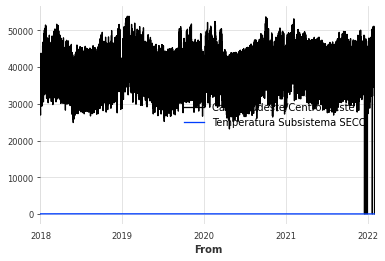

In [9]:

df.plot()

# WHATS YOUR DAMN PROBLEM?!
https://unit8co.github.io/darts/generated_api/darts.timeseries.html

In [11]:
df = darts.timeseries.TimeSeries.from_dataframe(df)

In [12]:
train, val = df.split_before(0.7)

# N-BEATS 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score, coefficient_of_variation
from darts.datasets import EnergyDataset



In [14]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [16]:
model_nbeats.fit(train, val_series=val, verbose=True)



[2022-03-26 18:33:19,082] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 25063 samples.
[2022-03-26 18:33:19,082] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 25063 samples.
[2022-03-26 18:33:19,224] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-26 18:33:19,224] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-26 18:33:19,230] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-03-26 18:33:19,230] WARNING | darts.models.forecasting.torch_forecasting_model | Dep

Epoch 9: 100%|██████████| 46/46 [01:04<00:00,  1.39s/it, loss=1.75e+06]


In [18]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

  0%|          | 0/2151 [00:00<?, ?it/s]

Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicting: 32it [00:00, ?it/s]
Predicti

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

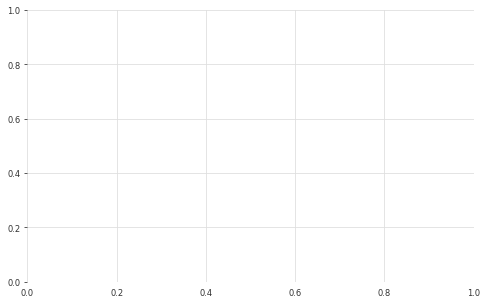

In [20]:
pred_series = model_nbeats.historical_forecasts(
    df,
    start=0.7,
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, df, "7 day", start_date=0.7)



TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

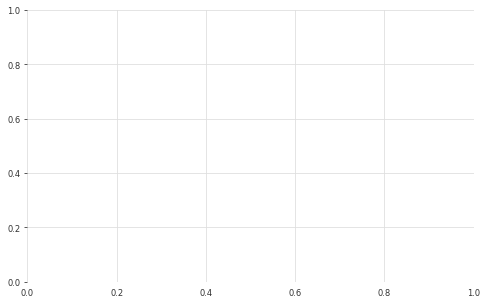

In [25]:
#display_forecast(pred_series, df, "7 day", start_date=0.7)
display_forecast(pred_series, df, "7 day")

In [36]:
coefficient_of_variation(df, pred_series)

429.0231405832128